In [1]:
import nltk
import pandas as pd
import matplotlib.pyplot as plt

# Used in the Lemmatizer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

/Users/faustotnc/.pyenv/versions/3.8.5/lib/python3.8/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


# Loading the Data

In [2]:
pfd     =  pd.read_csv("./datasets/PoetryFoundationData.csv")
pfd     =  pfd.sample(frac=1)  # Randomizes the data
emolex  =  pd.read_csv("./datasets/NRC-Emotion-Intensity-Lexicon-v1/NRC-Emotion-Intensity-Lexicon-v1.txt", sep="\t")
emolex  =  emolex.sample(frac=1)  # Randomizes the data

print("===================== Sample Data from the Poetry Foundation Dataset")
print(pfd["Poem"])
print("\n===================== Sample Data from the EmoLex dataset")
print(emolex)

===================== Sample Data from the Poetry Foundation Dataset
10913    \r\n\r\n                        Nobody was lef...
8660     \r\n\r\nOne last time I unlock the house where...
8952     \r\n\r\nMy grandmother said when she was young...
6205     \r\n\r\nFrom a ways, the sky and your hands\r\...
7271     \r\n\r\n\r\n\r\n\r\n\r\n\r\n\r\n(excerpt)\r\n\...
                               ...                        
6308     \r\n\r\nI got a letter through the post decree...
6679     \r\n\r\nCreo que si ... I believe   it will ra...
10305    \r\n\r\nEven when your friend, the radio, is s...
8672     \r\n\r\nI wish I could find that skinny, long-...
6671     \r\n\r\nAs I sd to my   \r\n\r\nfriend, becaus...
Name: Poem, Length: 13854, dtype: object

===================== Sample Data from the EmoLex dataset
             word       emotion  emotion-intensity-score
30         murder         anger                    0.897
4947       hooded          fear                    0.266
4850     or

# Processing the Data

## The Lemmatizer

In [3]:
# NOTE: This code is a modification of the code found in this article:
# https://www.machinelearningplus.com/nlp/lemmatization-examples-python/


# Init the Wordnet Lemmatizer
Lemmatizer = WordNetLemmatizer()

# Gets the WordNet POS tag for a word
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""

    tag = nltk.pos_tag([word])[0][1][0].upper()

    tag_dict = {
        "J": wordnet.ADJ,
        "N": wordnet.NOUN,
        "V": wordnet.VERB,
        "R": wordnet.ADV
    }

    wn = wordnet.NOUN

    return tag_dict.get(tag, wn)

# Lemmatizes the given word or list of words
def Lemmatize(words):
    if type(words) == str:
        return Lemmatizer.lemmatize(words, get_wordnet_pos(words))
    else:
        return [Lemmatize(word) for word in words]

In [4]:
# Tests the Lemmatizer
Lemmatize(["calculating", "feet"])

['calculate', 'foot']

## Processing the EmoLex Data

In [5]:
# A dictionary that maps each word in the emolex
# dataset to a 2-tuple of the emotion and
# intensity score associated to that word.
processedEmoLexData = dict()

emolexWords = Lemmatize(emolex["word"])
emolexLables = emolex["emotion"]
emolexScores = emolex["emotion-intensity-score"]

for w, l, s in zip(emolexWords, emolexLables, emolexScores):
    if (w not in processedEmoLexData):
        processedEmoLexData[w] = (l, s)
    else:
        # If the word is already present in the dictionary,
        # but now there is an emotion with a higher score
        # associated with that word, then we assign the new
        # emotion to the word.
        if (processedEmoLexData[w][1] < s):
            processedEmoLexData[w] = (l, s)

# Prints the first 15 words from the
# processed dictionary
count = 0
for w in processedEmoLexData:
    print(w + ':', processedEmoLexData[w])
    
    if (count >= 15):
        break
    else:
        count += 1

murder: ('fear', 0.9059999999999999)
hood: ('fear', 0.266)
ordnance: ('fear', 0.312)
divan: ('trust', 0.297)
bottomless: ('fear', 0.359)
deal: ('anticipation', 0.402)
opera: ('anticipation', 0.469)
venomous: ('anger', 0.818)
indonesia: ('trust', 0.297)
commonplace: ('trust', 0.45299999999999996)
absolution: ('trust', 0.617)
servant: ('trust', 0.344)
cultivate: ('trust', 0.555)
mastery: ('trust', 0.672)
cheerfulness: ('joy', 0.758)
pay: ('anticipation', 0.461)


In [6]:
# Guesses the emotion of the passed poem
def label_poem_emotion(poem):
    scores = dict()
    
    for word in nltk.word_tokenize(poem):
        if word.isalnum():
            word = Lemmatize(word.lower())

            if word in processedEmoLexData:
                emotion, score = processedEmoLexData[word]

                # Adds the new emotion to the `scores` dictionary
                # if it is not present, otherwise aggregates the
                # new score with the the already present score.
                if emotion not in scores:
                    scores[emotion] = score
                else:
                    scores[emotion] += score
                    
    # Sorts the emotions and return the one with highest value
    scores = sorted(scores.items(), key=lambda x: x[1], reverse=True)
    return scores[0] if len(scores) > 0 else ("**UNKNOWN**", 1)


# Tests the emotion labeler
print(label_poem_emotion("This unkind brutality makes me infuriated."))
print(label_poem_emotion("Oh, I love the bright days I spend with you!"))

('anger', 1.897)
('joy', 0.879)


## Processing the Poetry Foundation Dataset

In [7]:
# Assigns an emotions to each poem in the dataset
print("\n\n:: Labeling Poems...")
poemLabels = []
for poem in pfd["Poem"]:
    poemLabels.append(label_poem_emotion(poem)[0])

    # Prints a progress bar :)
    barLength = 50
    progress = round(len(poemLabels) / len(pfd) * 100)
    p = int((progress * barLength) / 100)
    bar = ("=" * p) + (" " * (barLength - p))
    print(f":: [{bar}] {str(progress)}% Done.", end="\r")

# Prints a success message after labeling the poems
print(f":: [{bar}] {str(progress)}% Done.")

# Generates a new dataframe with the poems and their label
# NOTE: this is the dataframe that will be used to train the
# our final model for generating new poems.
new_data = pd.DataFrame(data={
    "poem": pfd["Poem"],
    "emotion": poemLabels
})



:: Labeling Poems...
:: [==================================================] 100% Done.


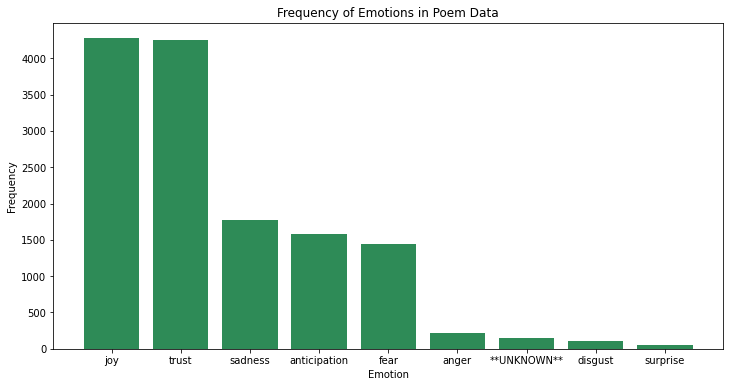

In [8]:
def show_emotion_freq_in_poems():
    freq = nltk.FreqDist(new_data["emotion"])

    plt.rcParams["figure.figsize"] = (12, 6)

    x, y = ([], [])
    for f in freq:
        x.append(f)
        y.append(freq[f])

    x_pos = [i for i, _ in enumerate(x)]

    plt.bar(x_pos, y, color='#2E8B57')
    plt.xlabel("Emotion")
    plt.ylabel("Frequency")
    plt.title("Frequency of Emotions in Poem Data")

    plt.xticks(x_pos, x)

    plt.show()
    
show_emotion_freq_in_poems()

# Data Analysis

## Statistical Data for the Poetry Foundation Dataset

In [9]:
allTokens = []
sentenceSizes = []
lineCounts = []


for poem in pfd["Poem"]:
    
    for word in nltk.word_tokenize(poem):
        if word.isalnum():
            # Computes the total number of tokens in the corpus
            allTokens.append(word)
    
    # Helps compute sentence statistics
    sentenceSizes.append(len(poem.split(".")))
    
    # Helps compute line statistics
    lineCounts.append(len(poem.split("\n")))
        
            
print("1) Total Number of Documents:", len(pfd))

print("2) Total Number of Tokens:", len(allTokens))
print("3) Total Number of Unique Tokens:", len(nltk.FreqDist(allTokens)))

print("4) Total Number of Sentences:", sum(sentenceSizes))
print("5) Avg. Number of Sentences in Document:", sum(sentenceSizes) / len(sentenceSizes))

print("6) Avg. Number of Lines in Document:", sum(lineCounts) / len(lineCounts))

1) Total Number of Documents: 13854
2) Total Number of Tokens: 3437308
3) Total Number of Unique Tokens: 125028
4) Total Number of Sentences: 172482
5) Avg. Number of Sentences in Document: 12.449978345604158
6) Avg. Number of Lines in Document: 58.50252634618161


## Statistical Data for the EmoLex Dataset

1) Total Number of Documents (Before Processing): 9921
2) Total Number of Unique Tokens (Before Processing): 5975
3) Total Number of Documents (After Processing): 5524
4) Total Number of Unique Tokens (After Processing): 5524


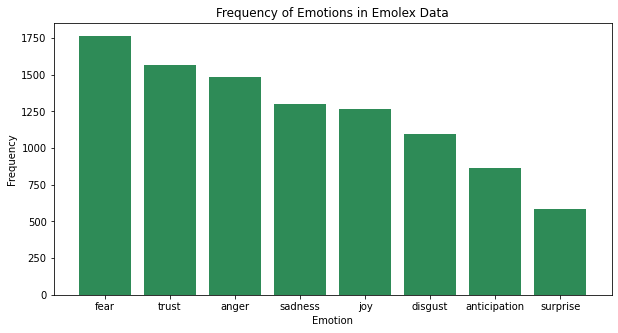

In [10]:
# Plots a graph of the emotion frequecy distribution
def show_emotion_freq():
    freq = nltk.FreqDist(emolex["emotion"])

    plt.rcParams["figure.figsize"] = (10, 5)

    x, y = ([], [])
    for f in freq:
        x.append(f)
        y.append(freq[f])

    x_pos = [i for i, _ in enumerate(x)]

    plt.bar(x_pos, y, color='#2E8B57')
    plt.xlabel("Emotion")
    plt.ylabel("Frequency")
    plt.title("Frequency of Emotions in Emolex Data")

    plt.xticks(x_pos, x)

    plt.show()

print("1) Total Number of Documents (Before Processing):", len(emolex))
print("2) Total Number of Unique Tokens (Before Processing):", len(nltk.FreqDist(emolex["word"])))

print("3) Total Number of Documents (After Processing):", len(processedEmoLexData))
print("4) Total Number of Unique Tokens (After Processing):", len(nltk.FreqDist(emolexWords)))

show_emotion_freq()